In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.optimize import minimize

import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph

from IPython.display import Image

In [2]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [3]:
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

QI_URL = 'https://api.quantum-inspire.com/'

In this notebook you will apply what you have just learned about cqasm and Quantum Inspire. We will consider a simple quantum algorithm, the quantum approximate optimization algorithm (QAOA), for which you will code the circuit in cqasm and send some jobs to real quantum hardware on the Quantum Inspire platform.

## 1. Recap: QAOA and MAXCUT

### Introduction to the Quantum Approximate Optimization Algorithm

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

Consider some combinatorial optimization problem with objective function $C:x\rightarrow \mathbb{R}$ acting on $n$-bit strings $x\in \{0,1\}^n$, domain $\mathcal{D} \subseteq \{0,1\}^n$, and objective

\begin{align}
     \max_{x \in \mathcal{D}} C(x).
\end{align}

In maximization, an approximate optimization algorithm aims to find a string $x'$ that achieves a desired approximation ratio $\alpha$, i.e.

\begin{equation}
    \frac{C(x')}{C^*}\geq \alpha,
\end{equation}

where $C^* = \max_{x \in \mathcal{D}} C(x)$.
In QAOA, such combinatorial optimization problems are encoded into a cost Hamiltonian $H_C$, a mixing Hamiltonian $H_M$ and some initial quantum state $\ket{\psi_0}$. The cost Hamiltonian is diagonal in the computational basis by design, and represents $C$ if its eigenvalues satisfy

\begin{align}
    H_C \ket{x} = C(x) \ket{x} \text{ for all } x \in  \{0,1\}^n.
\end{align}

The mixing Hamiltonian $H_M$ depends on $\mathcal{D}$ and its structure, and is in the unconstrained case (i.e. when $\mathcal{D}=\{0,1\}^n$) usually taken to be the transverse field Hamiltonian $H_M = \sum_{j} X_j$. Constraints (i.e. when $\mathcal{D}\subset \{0,1\}^n$) can be incorporated directly into the mixing Hamiltonian or are added as a penalty function in the cost Hamiltonian. The initial quantum state $\ket{\psi_0}$ is usually taken as the uniform superposition over all possible states in the domain. $\text{QAOA}_p$, parametrized in $\gamma=(\gamma_0,\gamma_1,\dots,\gamma_{p-1}),\beta=(\beta_0,\beta_1,\dots,\beta_{p-1})$, refers to a level-$p$ QAOA circuit that applies $p$ steps of alternating time evolutions of the cost and mixing Hamiltonians on the initial state. At step $k$, the unitaries of the time evolutions are given by

\begin{align}
    U_C(\gamma_k) = e^{-i \gamma_k H_C }, \label{eq:UC} \\
    U_M(\beta_k) = e^{-i \beta_k H_M }. \label{eq:UM}
\end{align}

So the final state $\ket{\gamma,\beta}$ of $\text{QAOA}_p$ is given by 

\begin{align}
    \ket{\gamma,\beta} = \prod_{k=0}^{p-1} U_M(\beta_k) U_C(\gamma_k) \ket{\psi_0}.
\end{align}

The expectation value $ F_p(\gamma,\beta)$ of the cost Hamiltonian for state $\ket{\gamma,\beta}$ is given by

\begin{align}
    F_p(\gamma,\beta) = 
    \bra{\gamma,\beta}H_C\ket{\gamma,\beta},
    \label{eq:Fp}
\end{align}

and can be statistically estimated by taking samples of $\ket{\gamma,\beta}$. The achieved approximation ratio (in expectation) of $\text{QAOA}_p$ is then

\begin{equation}
    \alpha = \frac{F_p(\gamma,\beta)}{C^*}.
\end{equation}

The parameter combinations of $\gamma,\beta$ are usually found through a classical optimization procedure that uses $F_p(\gamma,\beta)$ as a black-box function to be maximized.

### Example application: MAXCUT

MaxCut is an NP-hard optimisation problem that looks for an optimal 'cut' for a graph $G(V,E)$, in the sense that the cut generates a subset of nodes $S \subset V$ that shares the largest amount of edges with its complement $ V\setminus S$. In slightly modified form (omitting the constant), it has the following objective function

\begin{align}
\max_{s} \frac{1}{2} \sum_{
\langle i,j \rangle \in E} 1-s_i s_j,
\end{align}

where the $s_i\in\{-1,1\}$ are the variables and $i,j$ are the edge indices. This function can be easily converted into an Ising cost Hamiltonian, which takes the form

\begin{align}
H_C = \frac{1}{2}\sum_{\langle i,j\rangle \in E} I-Z_i Z_j.
\end{align}

We use the standard mixing Hamiltonian that sums over all nodes:

\begin{align}
H_M = \sum_{v \in V} X_v.
\end{align}

As the initial state $\ket{\Psi_0}$ we take the uniform superposition, given by

\begin{align}
\ket{\psi_0} = \frac{1}{\sqrt{2^{|V|}}}\sum_{x=0}^{2^{|V|}-1} \ket{x} 
\end{align}


The goal of this workshop is to guide you through an implemented code that simulates a small quantum computer running the QAOA algorithm applied to the MAXCUT problem. We will use qiskit as well as cqasm as SDK's. For the sake of run time, you will always run the classical optimization part using the qiskit simulator: it would take too long for our purposes to do the actual function evualtions in the classical optimization step on the hardware.

## 2. Some useful functions and intializations

We first define some useful functions to be used later throughout the code.

In [4]:
# Just some function to draw graphs
def draw_cc_graph(G,node_color='b',fig_size=4):
    plt.figure(figsize=(fig_size,fig_size))
    nx.draw(G, G.pos, 
        node_color= node_color,
        with_labels=True,
        node_size=1000,font_size=14)
    plt.show()

In [5]:
# Define the objective function
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut, negative value in agreement with the optimizer (which is a minimizer)
            cut -= 1
    return cut

# Brute force method
def brute_force(G):
    n = len(G.nodes)
    costs = np.zeros(0)
    costs=[]
    for i in range(2**n):
        calc_costs = -1*maxcut_obj(bin(i)[2:].zfill(n),G)
        costs.append(calc_costs)
    max_costs_bf = max(costs)
    index_max = costs.index(max(costs))
    max_sol_bf = bin(index_max)[2:].zfill(n)
    return max_costs_bf, max_sol_bf,costs


In [6]:
# Generating the distribution resulting from random guessing the solution
def random_guessing_dist(G):
    dictio= dict()
    n = len(G.nodes())
    for i in range(2**n):
        key = bin(i)[2:].zfill(n)
        dictio[key] = maxcut_obj(bin(i)[2:].zfill(n),G)
    RG_energies_dist = defaultdict(int)
    for x in dictio:
        RG_energies_dist[maxcut_obj(x,G)] += 1
    return RG_energies_dist

# Visualize multiple distributions
def plot_E_distributions(E_dists,p,labels):
    plt.figure()
    x_min = 1000
    x_max = - 1000
    width = 0.25/len(E_dists)
    for index,E_dist in enumerate(E_dists):
        pos = width*index-width*len(E_dists)/4 
        label = labels[index]
        X_list,Y_list = zip(*E_dist.items())
        X = -np.asarray(X_list)
        Y = np.asarray(Y_list)
        plt.bar(X + pos, Y/np.sum(Y), color = 'C'+str(index), width = width,label= label+', $p=$'+str(p))
        if np.min(X)<x_min:
            x_min = np.min(X)
        if np.max(X)>x_max:
            x_max = np.max(X)
    plt.xticks(np.arange(x_min,x_max+1))
    plt.legend()
    plt.xlabel('Objective function value')
    plt.ylabel('Probability')
    plt.show()


# Determinet the expected objective function value from the random guessing distribution
def energy_random_guessing(RG_energies_dist):
    energy_random_guessing = 0
    total_count = 0
    for energy in RG_energies_dist.keys():
        count = RG_energies_dist[energy]
        energy_random_guessing += energy*count
        total_count += count
    energy_random_guessing = energy_random_guessing/total_count
    return energy_random_guessing

### Test instances

G2:


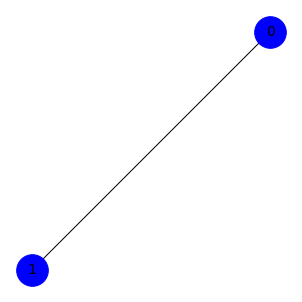

G3:


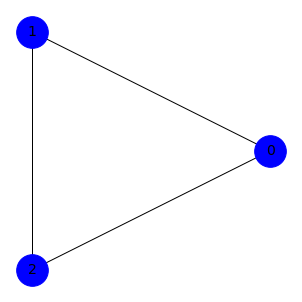

In [7]:
w2  = np.matrix([
 [0, 1],
 [1, 0]])
G2 = nx.from_numpy_matrix(w2)
positions = nx.circular_layout(G2)
G2.pos=positions
print('G2:')
draw_cc_graph(G2)


w3  = np.matrix([
 [0, 1, 1],
 [1, 0, 1],
 [1, 1, 0]])
G3 = nx.from_numpy_matrix(w3)
positions = nx.circular_layout(G3)
G3.pos=positions
print('G3:')
draw_cc_graph(G3)

## 3. Circuit generators

We provide you with an example written in qiskit. You have to write the one for cqasm yourself.

### Qiskit generators

In [8]:
class Qiskit(object):        
    # Cost operator:
    def get_cost_operator_circuit(G, gamma):
        N = G.number_of_nodes()
        qc = QuantumCircuit(N,N)
        for i, j in G.edges():
            qc.cx(i,j)
            qc.rz(2*gamma, j)
            qc.cx(i,j)
        return qc

    # Mixing operator
    def get_mixer_operator_circuit(G, beta):
        N = G.number_of_nodes()
        qc = QuantumCircuit(N,N)
        for n in G.nodes():
            qc.rx(2*beta, n)
        return qc
    
    # Build the circuit:
    def get_qaoa_circuit(G, beta, gamma):
        assert(len(beta) == len(gamma))
        p = len(beta) # number of unitary operations
        N = G.number_of_nodes()
        qc = QuantumCircuit(N,N)
        # first step: apply Hadamards to obtain uniform superposition
        qc.h(range(N))
        # second step: apply p alternating operators
        for i in range(p):
            qc.compose(Qiskit.get_cost_operator_circuit(G,gamma[i]),inplace=True)
            qc.compose(Qiskit.get_mixer_operator_circuit(G,beta[i]),inplace=True)
        # final step: measure the result
        qc.barrier(range(N))
        qc.measure(range(N), range(N))
        return qc



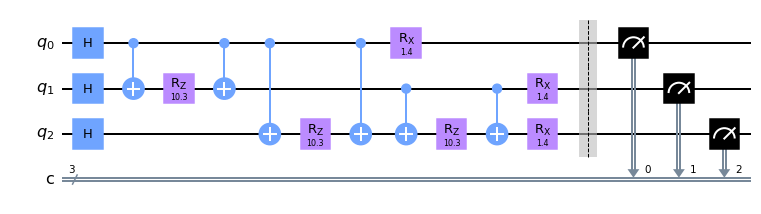

In [9]:
# Show the circuit for the G3 (triangle) graph
p = 1
beta = np.random.rand(p)*2*np.pi
gamma = np.random.rand(p)*2*np.pi
qc = Qiskit.get_qaoa_circuit(G3,beta, gamma)
qc.draw(output='mpl')


### cqasm generators

Now it is up to you to apply what we have learned about cqasm to write the script for the cost and mixing operators:

In [43]:
class Cqasm(object):
    
    ### We give them this part
    def get_qasm_header(N_qubits):
        """
        Create cQASM header for `N_qubits` qubits and prepare all in |0>-state.
        """
        header = f"""
version 1.0
qubits {N_qubits}
prep_z q[0:{N_qubits-1}]
"""
        return header
    
    def get_cost_operator(graph, gamma, p=1):
        ...

    def get_mixing_operator(graph, beta, p=1):
        ...

    def get_qaoa_circuit(graph, beta, gamma):
        """
        Create full QAOA circuit for given `graph` and angles `beta` and `gamma`.
        """
        assert len(beta) == len(gamma)
        p = len(beta) # number of layers
        N_qubits = graph.number_of_nodes()
        circuit_str = Cqasm.get_qasm_header(5) #N_qubits)

        # first step: apply Hadamards to obtain uniform superposition
        circuit_str += "{" + ' | '.join([f"H q[{i}]" for i in graph.nodes()]) + "}\n\n"
        # second step: apply p alternating operators
        circuit_str += '\n'.join([Cqasm.get_cost_operator(graph, gamma[i], i+1) 
                                  + Cqasm.get_mixing_operator(graph, beta[i], i+1) for i in range(p)])
        # final step: measure the result
        circuit_str += "\n"
        circuit_str += "measure_all"

        return circuit_str

## 4. Hybrid-quantum classical optimization

Since QAOA is usually adopted as a hybrid quantum-classical algorithm, we need to construct an outer loop which optimizes the estimated $\bra{\gamma,\beta}H\ket{\gamma,\beta}$.

In [44]:
# Black-box function that describes the energy output of the QAOA quantum circuit
def get_black_box_objective(G, p, SDK = 'qiskit', backend = None, shots=2**10):
    if SDK == 'cqasm':
        if not backend:
            backend = 'QX single-node simulator'
            backend_type = qi.get_backend_type_by_name(backend)
            def f(theta):
                # first half is betas, second half is gammas
                beta = theta[:p]
                gamma = theta[p:]
                qc = Cqasm.get_qaoa_circuit(G, beta, gamma)
                result = qi.execute_qasm(qc, backend_type=backend_type, number_of_shots=shots)
                counts = result['histogram'] 
                # return the energy
                return compute_maxcut_energy(counts, G)

    if SDK == 'qiskit':
        if not backend:
            backend = 'qasm_simulator'
        backend = Aer.get_backend(backend)
        def f(theta):
            # first half is betas, second half is gammas
            beta = theta[:p]
            gamma = theta[p:]
            qc = Qiskit.get_qaoa_circuit(G,beta, gamma)
            counts = execute(qc, backend,shots=shots).result().get_counts()
            # return the energy
            return compute_maxcut_energy(counts, G)
    else:
        return 'error: SDK not found'
    return f

# Estimate the expectation value based on the circuit output
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

## 5. A simple instance on the quantum inspire platform: 2-qubit case

Let us first consider the most simple MAXCUT instance. We have just two nodes, and an optimal cut with objective value 1 would be to place both nodes in its own set.

brute force method best cut:  1
best string brute force method: 01


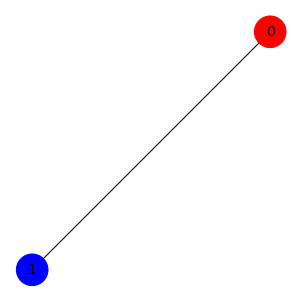

In [45]:
G=G2
max_costs_bf, max_sol_bf,costs = brute_force(G)
print("brute force method best cut: ",max_costs_bf)
print("best string brute force method:",max_sol_bf)

colors = ['red' if x == '0' else 'b' for x in max_sol_bf]
draw_cc_graph(G,node_color = colors)

Using qiskit, the circuit would look the following:

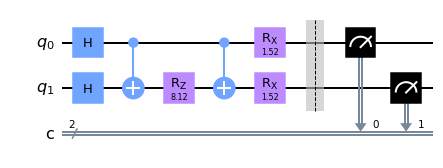

In [46]:
# Test and show circuit for some beta,gamma
p = 1
beta = np.random.rand(p)*np.pi
gamma = np.random.rand(p)*2*np.pi
qc = Qiskit.get_qaoa_circuit(G,beta, gamma)
qc.draw(output='mpl')

Now let's run our hybrid-quantum algorithm simulation using qiskit:

In [49]:
# Parameters that can be changed:
p = 1
lb = np.zeros(2*p)
ub = np.hstack([np.full(p, np.pi), np.full(p, 2*np.pi)])
init_point = np.random.uniform(lb, ub, 2*p)
shots = 2**10
optimiser = 'COBYLA'
max_iter = 100

# Training of the parameters beta and gamma
obj = get_black_box_objective(G,p,SDK='qiskit',shots=shots)
# Lower and upper bounds: beta \in {0, pi}, gamma \in {0, 2*pi}
bounds = [lb,ub]

# Maximum number of iterations: 100
res = minimize(obj, init_point, method=optimiser, bounds = bounds, options={'maxiter':max_iter, 'disp': True})
print(res)

     fun: -1.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([0.39495919, 2.33392237])


In [48]:
#Determine the approximation ratio:
print('Approximation ratio is',-res['fun']/max_costs_bf)

Approximation ratio is 0.9970703125


In [16]:
# Extract the optimal values for beta and gamma and run a new circuit with these parameters
optimal_theta = res['x']
qc = Qiskit.get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = execute(qc,backend = Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()

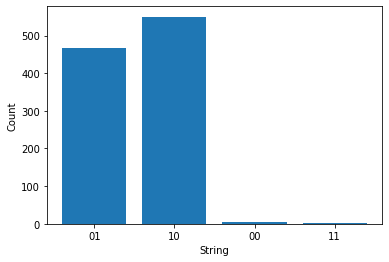

In [17]:
plt.bar(counts.keys(), counts.values())
plt.xlabel('String')
plt.ylabel('Count')
plt.show()

In [18]:
RG_dist = random_guessing_dist(G)

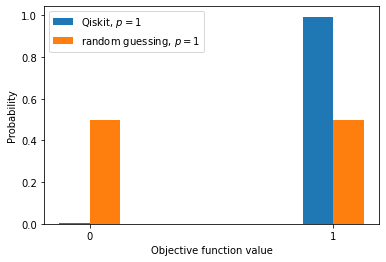

Energy from random guessing is -0.5


In [19]:
# Measurement distribution 
E_dist = defaultdict(int)
for k, v in counts.items():
    E_dist[maxcut_obj(k,G)] += v

plot_E_distributions([E_dist,RG_dist],p,['Qiskit','random guessing'])

E_random_guessing = energy_random_guessing(RG_dist)
print('Energy from random guessing is', E_random_guessing)

In [50]:
X_list,Y_list = zip(*E_dist.items())
X = -np.asarray(X_list)
Y = np.asarray(Y_list)
print('Probability of measuring the optimal solution is',Y[np.argmax(X)]/shots)

Probability of measuring the optimal solution is 0.9951171875


Now that we have obtained some good values for $\beta$ and $\gamma$ through classical simulation, let's see what Starmon-5 would give us.

The figure below shows the topology of Starmon-5. Since q0 is not connected to q1, we have to relabel the nodes. Networkx as such an option, by using 'nx.relabel_nodes(G,{1:2}' we can relabel node 1 as node 2. Since q0 is connected to q2, this does allow us to run our cqasm code on Starmon-5. For qiskit, this step is irrelevant as we have all-to-all connectivity in the simulation.

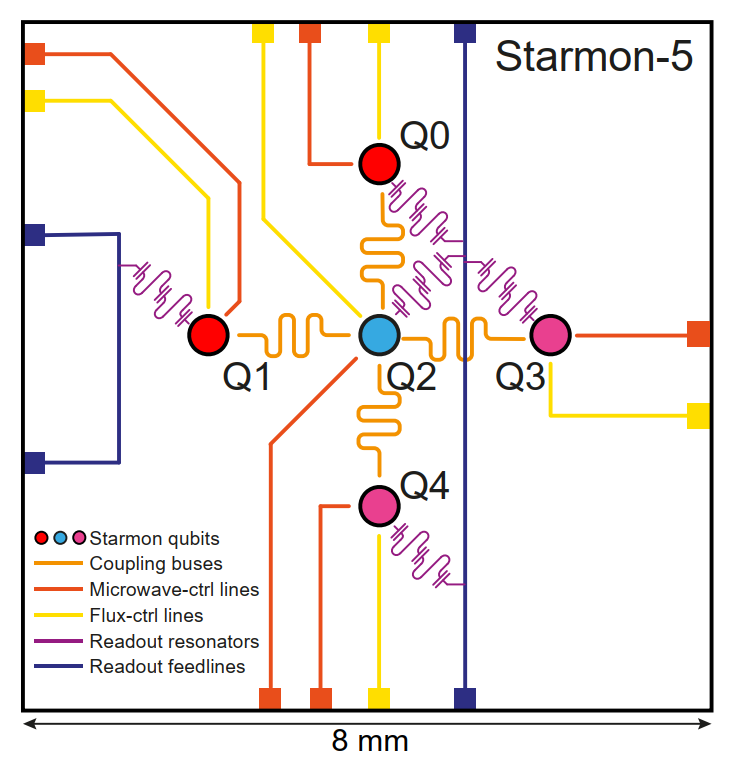

In [51]:
Image(filename='Starmon5.png')

In [52]:
qc_Cqasm = Cqasm.get_qaoa_circuit(nx.relabel_nodes(G, {1: 2}), optimal_theta[:p], optimal_theta[p:])
print(qc_Cqasm)


version 1.0
qubits 5
prep_z q[0:4]
{H q[0] | H q[2]}

.U_gamma_1
CNOT q[0], q[2]
Rz q[2], 5.633895595352522
CNOT q[0], q[2]
.U_beta_1
{Rx q[0], 3.807285952793924 | Rx q[2], 3.807285952793924}

measure_all


Now we run the Cqasm-circuit on the Starmon-5 Hardware.

In [53]:
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)

In [54]:
qiapi = QuantumInspireAPI(QI_URL, authentication)
result = qiapi.execute_qasm(qc_Cqasm, backend_type=qiapi.get_backend_type('Starmon-5'), number_of_shots=2**10)
counts_QI = result['histogram']

Inspecting 'counts_QI', we see that it returns the integer corresponding to the bit string result of the measurement 

In [25]:
counts_QI

OrderedDict([('0', 0.0791015625),
             ('1', 0.4033203125),
             ('2', 0.001953125),
             ('3', 0.0166015625),
             ('4', 0.3818359375),
             ('5', 0.0302734375),
             ('6', 0.0205078125),
             ('7', 0.001953125),
             ('8', 0.0029296875),
             ('9', 0.005859375),
             ('11', 0.0009765625),
             ('12', 0.02734375),
             ('13', 0.0029296875),
             ('14', 0.0009765625),
             ('16', 0.0029296875),
             ('17', 0.005859375),
             ('20', 0.0068359375),
             ('22', 0.0009765625),
             ('28', 0.0048828125),
             ('29', 0.001953125)])

Note that we measure more than just the two relevant qubits, since we had the 'measure all' command in the the cqasm code. The distribution over the strings looks the following:

{'00000': 0.0791015625, '00001': 0.4033203125, '00010': 0.001953125, '00011': 0.0166015625, '00100': 0.3818359375, '00101': 0.0302734375, '00110': 0.0205078125, '00111': 0.001953125, '01000': 0.0029296875, '01001': 0.005859375, '01011': 0.0009765625, '01100': 0.02734375, '01101': 0.0029296875, '01110': 0.0009765625, '10000': 0.0029296875, '10001': 0.005859375, '10100': 0.0068359375, '10110': 0.0009765625, '11100': 0.0048828125, '11101': 0.001953125}


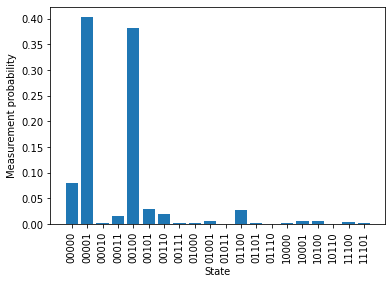

In [26]:
counts_bin = {}
for k,v in counts_QI.items():
    counts_bin[f'{int(k):05b}'] = v
print(counts_bin)
plt.bar(counts_bin.keys(), counts_bin.values())
plt.xlabel('State')
plt.ylabel('Measurement probability')
plt.xticks(rotation='vertical')
plt.show()

Let's create another counts dictionary with only the relevant qubits, which are q0 and q2:

In [27]:
counts_bin_red = defaultdict(float)
for string in counts_bin:
    q0 = string[-1]
    q1 = string[-3]
    counts_bin_red[(q0+q1)]+=counts_bin[string]

In [28]:
counts_bin_red

defaultdict(float,
            {'00': 0.0869140625,
             '10': 0.4326171875,
             '01': 0.443359375,
             '11': 0.037109375})

We now plot all distributions (qiskit, Starmon-5, and random guessing) in a single plot.

Approximation ratio on the hardware is 0.8759765625


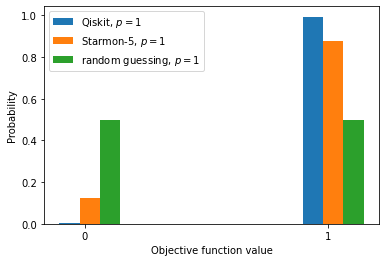

Probability of measuring the optimal solution is 0.8759765625
Expected approximation ratio random guessing is 0.5


In [29]:
#Determine the approximation ratio:
print('Approximation ratio on the hardware is',-compute_maxcut_energy(counts_bin_red,G)/max_costs_bf)

# Random guessing distribution
RG_dist = random_guessing_dist(G)

# Measurement distribution 
E_dist_S5 = defaultdict(int)
for k, v in counts_bin_red.items():
    E_dist_S5[maxcut_obj(k,G)] += v
    
plot_E_distributions([E_dist,E_dist_S5,RG_dist],p,['Qiskit','Starmon-5','random guessing'])


X_list,Y_list = zip(*E_dist_S5.items())
X = -np.asarray(X_list)
Y = np.asarray(Y_list)
print('Probability of measuring the optimal solution is',Y[np.argmax(X)])


E_random_guessing = energy_random_guessing(RG_dist)
print('Expected approximation ratio random guessing is', -E_random_guessing/max_costs_bf)

## 6. Compilation issues: the triangle graph


For the graph with just two nodes we already had some minor compilation issues, but this was easily fixed by relabeling the nodes. We will now consider an example for which relabeling is simply not good enough to get it mapped to the Starmon-5 toplogy.

brute force method best cut:  2
best string brute force method: 001


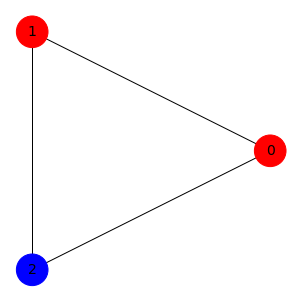

In [58]:
G=G3
max_costs_bf, max_sol_bf,costs = brute_force(G)
print("brute force method best cut: ",max_costs_bf)
print("best string brute force method:",max_sol_bf)

colors = ['red' if x == '0' else 'b' for x in max_sol_bf]
draw_cc_graph(G,node_color = colors)

Due to the topology of Starmon-5 this graph cannot be executed without any SWAPS. Therefore, we ask you to write a new circuit generator that uses SWAPS in order to make the algorithm work with the Starmon-5 topology. Let's also swap back to the original graph configuration, so that we can in the end measure only the qubits that correspond to a node in the graph (this is already written for you)

In [59]:
def QAOA_triangle_circuit_cqasm(graph, beta, gamma):
    circuit_str = Cqasm.get_qasm_header(5)
    circuit_str += "{" + ' | '.join([f"H q[{i}]" for i in graph.nodes()]) + "}\n\n"
    
    def get_triangle_cost_operator(graph, gamma, p):
        ....
    
    circuit_str += '\n'.join([get_triangle_cost_operator(graph, gamma[i], i+1) 
                              + Cqasm.get_mixing_operator(graph, beta[i], i+1) for i in range(p)])    
    circuit_str += "\n"
    circuit_str += "{" + ' | '.join([f"measure q[{i}]" for i in graph.nodes()]) + "}\n" 
    return circuit_str 

We now run the same procedure as before to obtain good parameter values

In [60]:
# Parameters that can be changed:
p = 1
lb = np.zeros(2*p)
ub = np.hstack([np.full(p, np.pi), np.full(p, 2*np.pi)])
init_point = np.random.uniform(lb, ub, 2*p)
shots = 2**10
optimiser = 'COBYLA'
max_iter = 100

# Training of the parameters beta and gamma
obj = get_black_box_objective(G,p,SDK='qiskit',shots=shots)
# Lower and upper bounds: beta \in {0, pi}, gamma \in {0, 2*pi}
bounds = [lb,ub]

# Maximum number of iterations: 100
res = minimize(obj, init_point, method=optimiser, bounds = bounds,options={'maxiter':max_iter, 'disp': True})
print(res)

C:\Users\jordi\Anaconda3\envs\EQTC_workshop\lib\site-packages\scipy\optimize\_minimize.py:544: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


     fun: -1.931640625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([2.89884114, 1.99787208])


In [61]:
#Determine the approximation ratio:
print('Approximation ratio is',-res['fun']/max_costs_bf)

# Extract the optimal values for beta and gamma and run a new circuit with these parameters
optimal_theta = res['x']
qc = Qiskit.get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = execute(qc,backend = Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()

# Random guessing distribution
RG_dist = random_guessing_dist(G)

# Measurement distribution 
E_dist = defaultdict(int)
for k, v in counts.items():
    E_dist[maxcut_obj(k,G)] += v

X_list,Y_list = zip(*E_dist.items())
X = -np.asarray(X_list)
Y = np.asarray(Y_list)
print('Probability of measuring the optimal solution is',Y[np.argmax(X)]/shots)

E_random_guessing = energy_random_guessing(RG_dist)
print('Expected approximation ratio random guessing is', -E_random_guessing/max_costs_bf)

Approximation ratio is 0.9658203125
Probability of measuring the optimal solution is 0.9541015625
Expected approximation ratio random guessing is 0.75


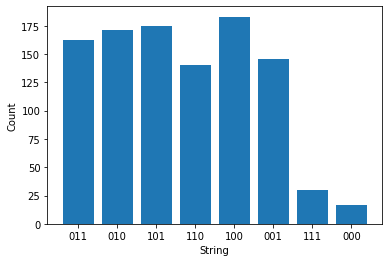

In [62]:
plt.bar(counts.keys(), counts.values())
plt.xlabel('String')
plt.ylabel('Count')
plt.show()

Let's run it on Starmon-5 again!

In [63]:
# Extract the optimal values for beta and gamma and run a new circuit with these parameters
optimal_theta = res['x']
qasm_circuit = QAOA_triangle_circuit_cqasm(G, optimal_theta[:p], optimal_theta[p:])
qiapi = QuantumInspireAPI(QI_URL, authentication)
result = qiapi.execute_qasm(qasm_circuit, backend_type=qiapi.get_backend_type('Starmon-5'), number_of_shots=shots)
counts = result['histogram']

print(qasm_circuit)
print(result)


version 1.0
qubits 5
prep_z q[0:4]
{H q[0] | H q[1] | H q[2]}

.U_gamma_1
SWAP q[0], q[2]
CNOT q[2], q[1]
Rz q[1], 3.9957441591320597
CNOT q[2], q[1]
SWAP q[0], q[2]
CNOT q[0], q[2]
Rz q[2], 3.9957441591320597
CNOT q[0], q[2]
CNOT q[1], q[2]
Rz q[2], 3.9957441591320597
CNOT q[1], q[2]
.U_beta_1
{Rx q[0], 5.797682279817749 | Rx q[1], 5.797682279817749 | Rx q[2], 5.797682279817749}

{measure q[0] | measure q[1] | measure q[2]}

{'id': 7069977, 'url': 'https://api.quantum-inspire.com/results/7069977/', 'job': 'https://api.quantum-inspire.com/jobs/7077998/', 'created_at': '2021-11-26T10:56:40.429243Z', 'number_of_qubits': 5, 'execution_time_in_seconds': 0.155648, 'raw_text': '', 'raw_data_url': 'https://api.quantum-inspire.com/results/7069977/raw-data/db877bd00c6e31d76aebcaadca7a24c8719d860cc1118387541ac4887982b476/', 'histogram': OrderedDict([('0', 0.09765625), ('1', 0.1376953125), ('2', 0.1552734375), ('3', 0.0712890625), ('4', 0.1474609375), ('5', 0.1943359375), ('6', 0.169921875), ('7

In [64]:
counts

OrderedDict([('0', 0.09765625),
             ('1', 0.1376953125),
             ('2', 0.1552734375),
             ('3', 0.0712890625),
             ('4', 0.1474609375),
             ('5', 0.1943359375),
             ('6', 0.169921875),
             ('7', 0.0263671875)])

{'000': 0.09765625, '001': 0.1376953125, '010': 0.1552734375, '011': 0.0712890625, '100': 0.1474609375, '101': 0.1943359375, '110': 0.169921875, '111': 0.0263671875}


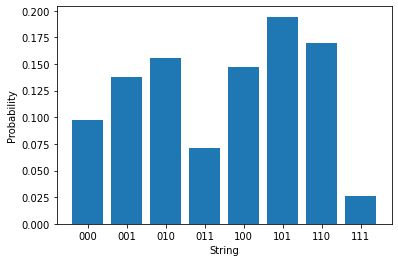

In [65]:
counts_bin = {}
for k,v in counts.items():
    counts_bin[f'{int(k):03b}'] = v
print(counts_bin)
plt.bar(counts_bin.keys(), counts_bin.values())
plt.xlabel('String')
plt.ylabel('Probability')
plt.show()

Approximation ratio on the hardware is 0.8837890625


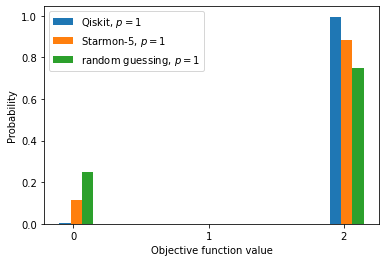

Probability of measuring the optimal solution is 0.8837890625
Expected approximation ratio random guessing is 0.75


In [38]:
#Determine the approximation ratio:
print('Approximation ratio on the hardware is',-compute_maxcut_energy(counts_bin,G)/max_costs_bf)

# Random guessing distribution
RG_dist = random_guessing_dist(G)

# Measurement distribution 
E_dist_S5 = defaultdict(int)
for k, v in counts_bin.items():
    E_dist_S5[maxcut_obj(k,G)] += v
    
plot_E_distributions([E_dist,E_dist_S5,RG_dist],p,['Qiskit','Starmon-5','random guessing'])


X_list,Y_list = zip(*E_dist_S5.items())
X = -np.asarray(X_list)
Y = np.asarray(Y_list)
print('Probability of measuring the optimal solution is',Y[np.argmax(X)])


E_random_guessing = energy_random_guessing(RG_dist)
print('Expected approximation ratio random guessing is', -E_random_guessing/max_costs_bf)

## 7. More advanced questions

Some questions you could look at:

- What is the performance on other graph instances?
- How scalable is this hardware for larger problem sizes?
- How much can the circuit be optimized for certain graph instances?
- Are the errors perfectly random or is there some correlation?
- Are there tricks to find good parameters? 